In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install --upgrade pandas

    100% |████████████████████████████████| 10.1MB 4.0MB/s 
fastai 1.0.46 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: pandas 0.22.0
    Uninstalling pandas-0.22.0:
      Successfully uninstalled pandas-0.22.0


In [1]:
!ls "drive/My Drive/Colab Notebooks/data"

GoogleNews-vectors-negative300.bin.gz  news_proc_9_3_19.pickle


# Imports, loads and Train/test split
---

In [0]:
import pandas as pd
import numpy as np

#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
#import swifter

from matplotlib import pyplot as plt
from matplotlib import style
#Nicer style
style.use('seaborn')
import seaborn as sns

from tensorflow import keras as k

from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [0]:
data = pd.read_pickle('drive/My Drive/Colab Notebooks/data/news_proc_9_3_19.pickle')#.reset_index()
data = data.dropna()

In [0]:
#dfake = data[data['type'] == 'fake']
#dtrue = data[data['type'] == 'truth']
#dclic = data[data['type'] == 'click']

#data = pd.concat([dfake.head(10000), dtrue, dclic])

#del dfake, dtrue, dclic

In [6]:
len_content = len(data['content'][0])
len_title = len(data['title'][0])

print("Max len content: {}".format(len_content))
print("Max len title: {}".format(len_title))

Max len content: 1695
Max len title: 13


In [0]:
model = KeyedVectors.load_word2vec_format("drive/My Drive/Colab Notebooks/data/GoogleNews-vectors-negative300.bin.gz", binary=True, limit=50000)

In [0]:
embed_mat = np.zeros((50000,300))
for i, e in model.vocab.items():
    embed_mat[e.index] = model[i]

**Tran/test split**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    data[['content', 'title']], data['one_hot_label'], test_size=0.5, random_state=1)

In [0]:
X_train_title = X_train['title']
X_train_content = X_train['content']

X_test_title = X_test['title']
X_test_content = X_test['content']

In [0]:
train_fit = [np.asarray(X_train_title.tolist()), 
             np.asarray(X_train_content.tolist())]

test_fit = [np.asarray(X_test_title.tolist()), 
             np.asarray(X_test_content.tolist())]

In [0]:
del data
del X_train_title, X_train_content

# LSTM

In [0]:
#input_title
title_input = k.layers.Input(shape=(len_title,), name='title_input')
inp = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False)(title_input)
x = k.layers.CuDNNLSTM(100)(inp)


#input_content
content_input = k.layers.Input(shape=(len_content,), name='content_input')
inp2 = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False)(content_input)
x2 = k.layers.CuDNNLSTM(300)(inp2)


#Merge
x = k.layers.concatenate([x, x2])

#Common part
x = k.layers.Dense(100, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)

out = k.layers.Dense(4, activation='softmax')(x)

#Build model
model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

model.compile(k.optimizers.Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=['acc'])

model.summary()

In [33]:
hist = model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=128, epochs=30,
          callbacks = [k.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.1)], validation_split=0.3)

Train on 32758 samples, validate on 14040 samples
Epoch 1/30
32758/32758 [==============================] - 233s 7ms/sample - loss: 1.3193 - acc: 0.3532 - val_loss: 1.1708 - val_acc: 0.4907
Epoch 2/30
32758/32758 [==============================] - 231s 7ms/sample - loss: 1.1242 - acc: 0.5117 - val_loss: 1.0572 - val_acc: 0.5515
Epoch 3/30
32758/32758 [==============================] - 228s 7ms/sample - loss: 1.0387 - acc: 0.5542 - val_loss: 1.0025 - val_acc: 0.5736
Epoch 4/30
32758/32758 [==============================] - 228s 7ms/sample - loss: 0.9922 - acc: 0.5819 - val_loss: 0.9777 - val_acc: 0.5840


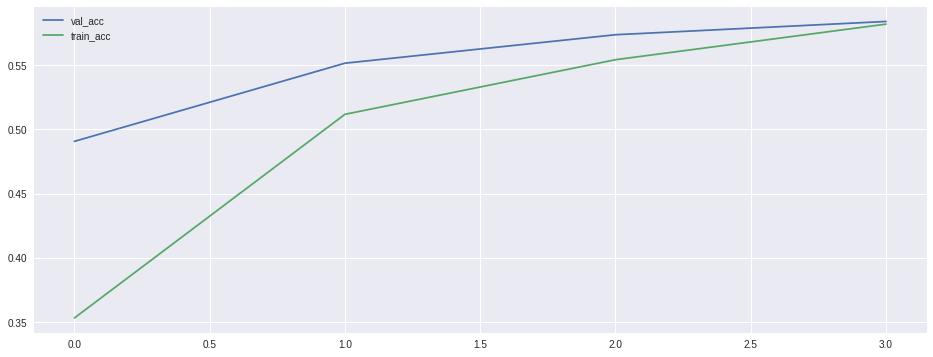

In [34]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_acc'], label='val_acc')
plt.plot(hist.history['acc'], label='train_acc')
plt.legend()

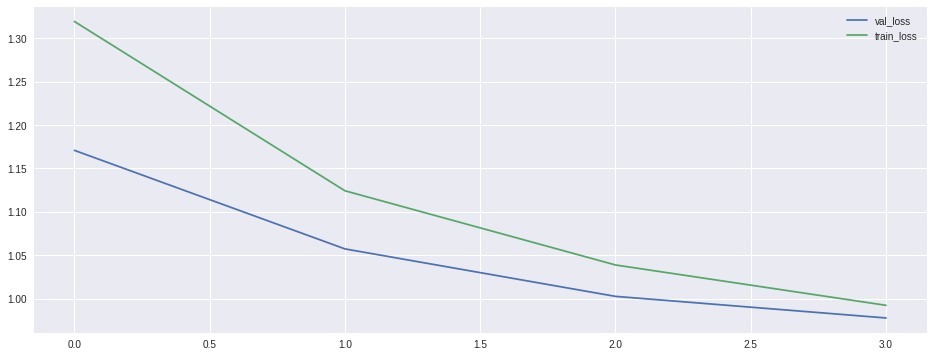

In [35]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['loss'], label='train_loss')
plt.legend()

In [36]:
test_pred = model.predict(test_fit)
accuracy_score(np.array(y_test.tolist()), test_pred.round())

0.4388555311010919

In [37]:
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.60      0.23      0.33      9004
           1       0.76      0.50      0.60      8664
           2       0.65      0.53      0.58     14415
           3       0.76      0.44      0.56     14716

   micro avg       0.70      0.44      0.54     46799
   macro avg       0.69      0.43      0.52     46799
weighted avg       0.69      0.44      0.53     46799
 samples avg       0.44      0.44      0.44     46799



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[[6096  334 1770  804]
 [3436 4350  524  354]
 [5401  452 7632  930]
 [5815  588 1848 6465]]


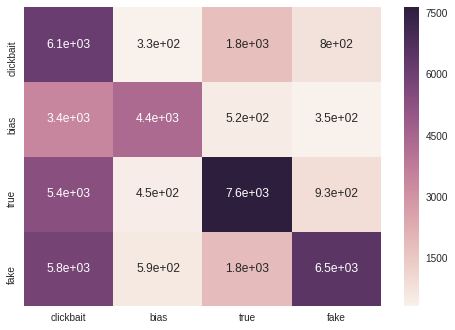

In [39]:
matrix = confusion_matrix(np.array(y_test.tolist()).argmax(axis=1), test_pred.round().argmax(axis=1))
print(matrix)

df_cm = pd.DataFrame(matrix, columns=['clickbait', 'bias', 'true', 'fake'], index=['clickbait', 'bias', 'true', 'fake'])
sns.heatmap(df_cm, annot=True)

In [0]:
LSTM_PATH = 'drive/My Drive/Colab Notebooks/weights/lstm.h5'

In [0]:
model.save(LSTM_PATH)

#Redes convolucionales

In [40]:
#input_title
title_input = k.layers.Input(shape=(len_title,), name='title_input')
inp = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False, name='embed_title')(title_input)

x = k.layers.Conv1D(filters = 5, kernel_size=4, strides=2, activation='relu', name='Conv1Title')(inp)
x = k.layers.MaxPool1D(pool_size = 2, name='Pool1Title')(x)
x = k.layers.Flatten()(x)
x = k.layers.Dense(50, activation='relu', name='Dense1Title', kernel_regularizer='l2')(x)

#input_content
content_input = k.layers.Input(shape=(len_content,), name='content_input')
inp2 = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False, name='embed_content')(content_input)
x2 = k.layers.Conv1D(filters = 40, kernel_size = 16, strides = 2, activation='relu', name='Conv1Content')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4, name='Pool1Content')(x2)

#Added
x2 = k.layers.Conv1D(filters = 80, kernel_size = 16, strides = 4, activation='relu', name='Conv2Content')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4, name='Pool2Content')(x2)
#

x2 = k.layers.Flatten()(x2)
x2 = k.layers.Dense(100, activation='relu', kernel_regularizer='l2', name='Dense1Content')(x2)


#Merge
x = k.layers.concatenate([x, x2])

#Common part
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
out = k.layers.Dense(4, activation='softmax')(x)


#Build model
model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

model.compile(k.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        (None, 13)           0                                            
__________________________________________________________________________________________________
content_input (InputLayer)      (None, 1695)         0                                            
__________________________________________________________________________________________________
embed_title (Embedding)         (None, 13, 300)      15000000    title_input[0][0]                
__________________________________________________________________________________________________
embed_content (Embedding)       (None, 1695, 300)    15000000    content_input[0][0]              
__________________________________________________________________________________________________
Conv1Title

In [41]:
hist = model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=128, epochs=20,
          callbacks = [k.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.1)], validation_split=0.3)

Train on 32758 samples, validate on 14040 samples
Epoch 1/20
32758/32758 [==============================] - 35s 1ms/sample - loss: 1.1138 - acc: 0.6178 - val_loss: 0.7385 - val_acc: 0.7548
Epoch 2/20
32758/32758 [==============================] - 34s 1ms/sample - loss: 0.6840 - acc: 0.7951 - val_loss: 0.6888 - val_acc: 0.7851
Epoch 3/20
32758/32758 [==============================] - 34s 1ms/sample - loss: 0.5312 - acc: 0.8727 - val_loss: 0.7155 - val_acc: 0.7958
Epoch 4/20
32758/32758 [==============================] - 34s 1ms/sample - loss: 0.4117 - acc: 0.9246 - val_loss: 0.8038 - val_acc: 0.8001


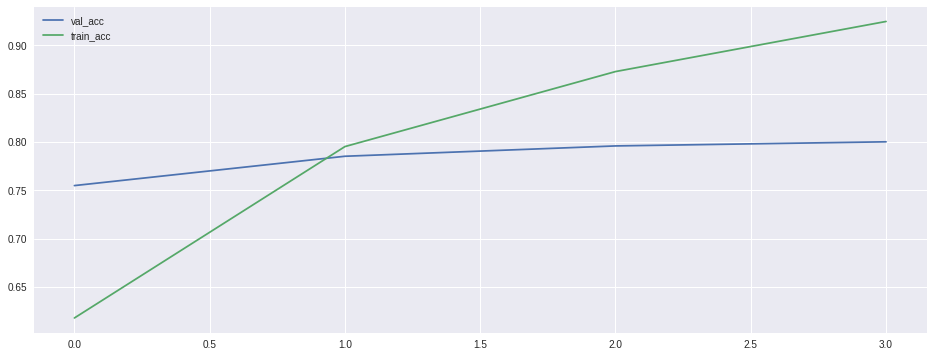

In [42]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_acc'], label='val_acc')
plt.plot(hist.history['acc'], label='train_acc')
plt.legend()

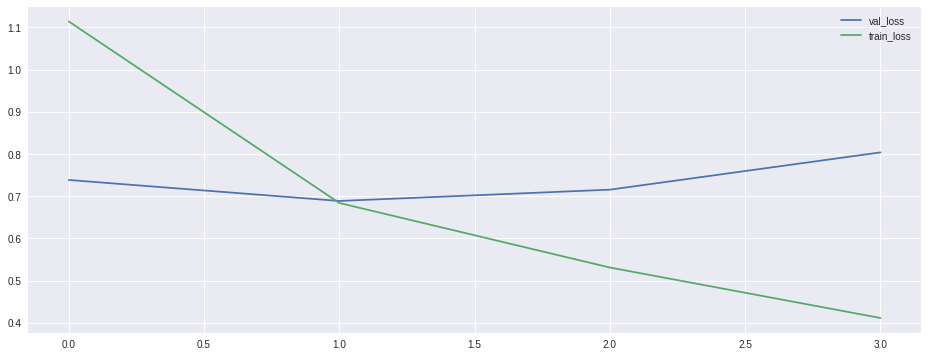

In [43]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['loss'], label='train_loss')
plt.legend()

In [44]:
test_pred = model.predict(test_fit)
accuracy_score(np.array(y_test.tolist()), test_pred.round())

0.7855723412893438

In [45]:
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.82      0.58      0.68      9004
           1       0.92      0.87      0.89      8664
           2       0.87      0.80      0.83     14415
           3       0.72      0.85      0.78     14716

   micro avg       0.81      0.79      0.80     46799
   macro avg       0.83      0.77      0.79     46799
weighted avg       0.82      0.79      0.80     46799
 samples avg       0.79      0.79      0.79     46799



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[[ 5677   164   685  2478]
 [  207  7535   210   712]
 [  922   195 11533  1765]
 [ 1044   305   849 12518]]


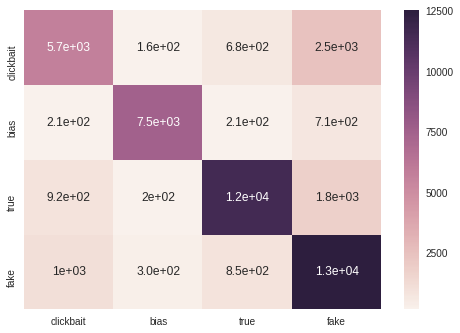

In [46]:
matrix = confusion_matrix(np.array(y_test.tolist()).argmax(axis=1), test_pred.round().argmax(axis=1))
print(matrix)

#Plot
df_cm = pd.DataFrame(matrix, columns=['clickbait', 'bias', 'true', 'fake'], index=['clickbait', 'bias', 'true', 'fake'])
sns.heatmap(df_cm, annot=True)

In [0]:
CONV_PATH = 'drive/My Drive/Colab Notebooks/weights/conv.h5'
model.save(CONV_PATH)